In [2]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
from sqlalchemy import create_engine

In [3]:
# read in the csv files 
dn = pd.read_csv("NOTEEVENTS.csv")  # contains all pateints 
d_icd = pd.read_csv("DIAGNOSES_ICD.csv") # contains the icd codes with the corresponding patients
d_icd_d = pd.read_csv("D_ICD_DIAGNOSES.csv")  # contains the icd codes with their corresponding names 
comorb = pd.read_csv("Comorb.csv")  # conatins the preprocessed comorbidities per patient

/var/folders/sz/811cct8d1dl6kw_86qz_k2800000gn/T/ipykernel_28052/3777173221.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  dn = pd.read_csv("/Users/macbook/Downloads/NOTEEVENTS.csv")


In [7]:
dn.drop_duplicates(subset=['SUBJECT_ID'])

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...
5,179,53181,170490.0,2172-03-08,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2172-3-5**] D...
6,180,20646,134727.0,2112-12-10,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2112-12-8**] ...
...,...,...,...,...,...,...,...,...,...,...,...
2082886,2075455,31666,154032.0,2145-07-12,2145-07-12 04:22:00,2145-07-12 04:39:00,Nursing/other,Report,19157.0,NaN,Admission Note\nBaby Girl [**Name2 (NI) 5203**...
2082888,2075457,31667,197301.0,2192-08-21,2192-08-21 10:18:00,2192-08-21 10:23:00,Nursing/other,Report,14989.0,NaN,Nursing admit/transfer note\nBB [**Known lastn...
2082938,2077235,31790,132855.0,2164-09-15,2164-09-15 02:48:00,2164-09-15 02:55:00,Nursing/other,Report,20318.0,NaN,Sepsis Eval Nursing Note:\n\nBaby boy [**Known...
2083082,2079379,32151,115098.0,2199-09-22,2199-09-22 21:15:00,2199-09-22 21:22:00,Nursing/other,Report,16929.0,NaN,Neonatology Attending Triage Note\nAsked to ev...


In [11]:
d_icd_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14567 entries, 0 to 14566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       14567 non-null  int64 
 1   ICD9_CODE    14567 non-null  object
 2   SHORT_TITLE  14567 non-null  object
 3   LONG_TITLE   14567 non-null  object
dtypes: int64(1), object(3)
memory usage: 455.3+ KB


In [12]:
# ICD 9 codes related with T1DM, manually extracted
ICD_9_D = ["25001", "25003", "25011", "25013", "25021", "25023", "25031", "25033", "25041", "25043", "25051", "25053", "25061", "25063", "25071", "25073", "25081", "25083", "25091", "25093"]

In [14]:
# only take the patients having diabetes type 1 related icd codes
d_typ1_2 = d_icd['ICD9_CODE'].isin(ICD_9_D)

In [15]:
t1 = d_icd[d_typ1_2]  # extracting patients with T1DM from database of all patients

In [17]:
t1 = t1.drop_duplicates(subset=['SUBJECT_ID']) 

In [18]:
t1_sub_id = t1['SUBJECT_ID']  # only storing subject id

In [19]:
t1_sub_id

788          25
1847        192
2283        141
3331        234
3519        263
          ...  
646810    96920
647011    95694
647454    97539
649592    99928
650036    97345
Name: SUBJECT_ID, Length: 998, dtype: int64

In [20]:
# subject ids identified from the discharge summary text files in the previous script and convert it to an array
sub_ID = [25,141,192,234,263,271,323,342,347,353,382,402,464,494,518,571,629,630,671,672,715,741,745,770,824,894,924,998,1027,1104,1139,1152,1162,1287,1358,1375,1422,1478,1493,1496,1524,1544,1586,1701,1780,1801,1899,1900,1905,1944,1987,2006,2045,2091,2133,2169,2185,2211,2243,2298,2345,2452,2487,2562,2599,2628,2641,2667,2755,2769,2771,2788,2791,2830,2860,2894,2908,2947,2973,2984,3042,3084,3133,3171,3176,3236,3241,3280,3328,3388,3442,3490,3543,3559,3577,3633,3647,3734,3738,3759,3876,3929,3952,4104,4112,4113,4258,4308,4313,4521,4577,4588,4589,4611,4619,4635,4640,4690,4696,4748,4792,4859,4862,4873,4948,4962,5020,5023,5031,5124,5139,5292,5327,5397,5399,5453,5496,5559,5658,5661,5669,5686,5689,5752,5772,5790,5794,5867,5882,5909,5939,5953,5973,5978,6014,6035,6079,6170,6179,6186,6249,6257,6314,6315,6321,6353,6375,6440,6466,6470,6498,6503,6510,6534,6553,6672,6685,6687,6756,6845,6849,6868,6998,7001,7029,7105,7125,7197,7237,7299,7476,7546,7567,7621,7666,7691,7720,7773,7789,7809,7815,7916,7961,7992,8006,8021,8028,8057,8143,8215,8291,8393,8447,8449,8452,8572,8601,8670,8678,8724,8734,8799,8820,8948,8949,8983,9036,9107,9112,9191,9216,9225,9266,9395,9408,9484,9531,9535,9628,9726,9811,9820,9829,9833,9900,9962,9977,10028,10167,10174,10319,10320,10363,10402,10412,10425,10457,10487,10559,10602,10725,10751,10818,10879,10932,10954,10957,10971,11003,11061,11154,11172,11178,11216,11229,11230,11242,11280,11294,11335,11338,11378,11390,11421,11472,11516,11566,11597,11601,11622,11636,11669,11757,11785,11791,11813,11827,11861,11897,11920,12008,12070,12135,12145,12157,12184,12203,12242,12403,12412,12508,12519,12556,12706,12709,12782,12829,12957,12965,13026,13027,13033,13165,13174,13205,13214,13216,13242,13251,13286,13318,13330,13351,13353,13394,13395,13401,13406,13413,13494,13502,13507,13516,13541,13627,13648,13731,13755,13993,14049,14102,14131,14154,14193,14256,14332,14412,14416,14458,14465,14496,14519,14553,14573,14611,14640,14669,14701,14748,14772,14869,14928,14956,14985,15008,15036,15122,15160,15168,15226,15236,15246,15265,15280,15464,15473,15485,15578,15739,15744,15763,15852,15875,15948,15970,16076,16084,16115,16223,16305,16312,16419,16421,16465,16590,16657,16678,16802,16843,16873,16997,17027,17052,17072,17131,17137,17318,17324,17328,17370,17423,17438,17455,17596,17633,17657,17686,17807,17882,17922,17944,17966,17997,18022,18088,18124,18134,18139,18187,18268,18288,18317,18377,18393,18559,18604,18625,18711,18744,18780,18846,18888,18894,18936,18992,18999,19008,19053,19119,19211,19213,19227,19302,19330,19345,19423,19434,19516,19527,19549,19571,19606,19620,19689,19714,19772,19812,19841,19953,19977,20004,20049,20066,20130,20133,20181,20208,20238,20259,20260,20308,20356,20374,20457,20479,20630,20631,20678,20706,20746,20747,20770,20794,20829,20862,20913,20931,21015,21019,21042,21093,21180,21246,21318,21382,21399,21431,21447,21452,21483,21507,21537,21538,21598,21613,21633,21712,21750,21819,21859,21881,21903,21955,21975,21988,22098,22119,22231,22280,22298,22492,22525,22557,22585,22677,22778,22823,22852,22853,22931,22941,22970,23039,23055,23100,23197,23226,23371,23380,23389,23519,23521,23657,23680,23687,23711,23771,23779,23840,23849,23876,23877,23916,23917,23933,24032,24072,24224,24236,24257,24401,24462,24499,24510,24601,24629,24659,24663,24691,24855,24858,24870,24938,24995,25022,25030,25111,25145,25178,25180,25216,25220,25228,25235,25255,25317,25329,25335,25418,25591,25668,25691,25786,25796,25822,25835,25876,25889,25935,25941,26057,26067,26095,26101,26161,26174,26234,26248,26260,26274,26281,26324,26407,26477,26494,26499,26519,26563,26605,26710,26759,26768,26865,26898,26901,26925,26932,26946,26996,27062,27114,27175,27198,27202,27205,27210,27252,27336,27379,27398,27434,27574,27575,27616,27634,27643,27694,27721,27758,27809,27863,27877,27905,27913,27924,28049,28067,28119,28192,28212,28419,28435,28487,28540,28566,28806,28862,28880,28902,28917,28941,28948,28960,29202,29231,29411,29426,29504,29541,29553,29558,29650,29682,29722,29834,29932,29968,30041,30088,30102,30156,30198,30239,30453,30486,30610,30707,30755,30789,30908,30962,30977,31026,31112,31198,31235,31247,31368,31382,31542,31698,31717,31903,32035,32160,32195,32234,32293,32296,32371,32460,32486,32598,32616,32677,32786,32797,40216,40560,40586,40978,41163,41413,41624,41702,41724,41782,41934,41982,42155,42158,42211,42217,42288,42776,42919,42920,42948,43047,43061,43274,43543,43585,43724,43982,43983,44058,44166,44342,44377,44566,45213,45277,45521,45772,45783,45791,45974,46067,46340,46415,46429,46498,46588,46776,46953,46962,47058,47247,47272,47287,47956,47993,48064,48233,48254,48327,48340,48388,48756,48872,48986,49104,49552,49603,49638,49778,50379,50627,51025,51039,51078,51484,51545,52097,52248,52370,52478,52615,52631,52687,52967,53247,53722,53897,54005,54132,54353,54806,55232,55332,55370,55573,55700,55725,55871,55973,56128,56405,56620,56714,57139,57342,57460,57468,57529,57550,57599,57642,57751,58031,58055,58163,58337,58526,59246,59268,59494,59592,59687,59726,59742,59752,59828,59848,60807,60960,61111,61551,61711,61949,62204,62232,62581,62681,62693,63098,63734,63961,64043,64153,64354,64873,64911,64995,65007,65154,65232,65609,65656,65848,65883,65887,65949,65950,66079,66109,66384,66505,66765,66898,66986,67393,67474,67624,67934,68035,68401,68602,68827,68949,69021,69208,69367,69371,69388,69518,69577,69624,69896,70077,70206,70355,70382,70386,70473,70499,70508,70516,70899,70912,71194,71211,71364,71525,71536,71880,72248,72407,72421,72795,72819,73038,73241,73339,73395,73582,73843,73874,74319,74364,74529,74786,74851,74913,75023,75496,75507,75668,75795,75864,75919,76118,76547,76558,76594,76846,76994,77018,77031,77099,77430,77787,77801,77805,77892,77893,78023,78288,78504,78536,78902,79132,79365,79427,79452,79557,79915,79931,80121,80190,80281,80350,80536,80602,80606,81193,81236,81303,81443,81543,81602,81848,81904,82000,82023,82065,82079,82189,82512,82598,83079,83099,83156,83564,84144,84874,85245,85397,85517,85566,85685,86621,86754,86765,86948,87160,87266,87708,87782,87823,88099,88265,88518,88594,88773,89205,89292,89369,89536,89799,90198,90273,90302,90333,90436,90884,91000,91017,91249,91384,92379,92407,92516,92800,93039,93089,93162,93194,93203,93541,93638,93893,94553,94762,94828,94937,94956,95339,95599,95694,96040,96057,96260,96442,96686,96920,97345,97441,97539,97924,97976,98103,98182,98220,98438,98749,98831,98899,99096,99260,99294,99383,99444,99650,99928]
sub_ID = np.asarray(sub_ID)

In [22]:
len(sub_ID)

1106

In [23]:
typ_1 = dn['SUBJECT_ID'].isin(sub_ID)

In [24]:
typ_1

0          False
1          False
2          False
3          False
4          False
           ...  
2083175    False
2083176    False
2083177    False
2083178    False
2083179    False
Name: SUBJECT_ID, Length: 2083180, dtype: bool

In [25]:
typ1= dn[typ_1]  # take all the diabetes patients identified from the text files

In [28]:
typ1.drop_duplicates(subset=['SUBJECT_ID'])

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
186,111,30977,160489.0,2194-02-19,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2194-2-16**] ...
257,448,11178,169254.0,2158-01-09,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2158-1-5**] D...
259,450,15008,109252.0,2110-01-10,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2110-1-6**] Discharg...
272,538,3734,154629.0,2110-08-30,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2110-8-26**] Dischar...
289,555,74913,180080.0,2193-08-07,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2193-8-5**] D...
...,...,...,...,...,...,...,...,...,...,...,...
326255,324134,28917,199720.0,2118-03-22,2118-03-22 04:18:00,2118-03-22 04:33:55,Nursing,Nursing Progress Note,14419.0,NaN,"27 yo female pt with h/o bipolar disorder ,DM ..."
859846,860962,11230,161629.0,2198-04-25,2198-04-25 06:17:00,NaN,Radiology,"PELVIS, NON-OBSTETRIC",NaN,NaN,"[**2198-4-25**] 6:17 AM\n PELVIS, NON-OBSTETRI..."
926187,933525,25335,161832.0,2195-10-10,2195-10-10 19:24:00,NaN,Radiology,CT C-SPINE W/O CONTRAST,NaN,NaN,[**2195-10-10**] 7:24 PM\n CT C-SPINE W/O CONT...
945052,957613,11622,168384.0,2188-05-23,2188-05-23 04:18:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2188-5-23**] 4:18 AM\n CHEST (PORTABLE AP) ...


Extracting birtdate and calculating the age from discharge summary text files of each patient

In [30]:
import re

def extract_dates_from_text(text):
    # Definiere die Muster für "Admission Date" und "Date of Birth"
    admission_date_pattern = r'Admission Date: \[\*\*(\d{4}-\d{1,2}-\d{1,2})\*\*]'
    date_of_birth_pattern = r'Date of Birth: \[\*\*(\d{4}-\d{1,2}-\d{1,2})\*\*]'

    # Suche nach den Mustern im Text
    admission_date_match = re.search(admission_date_pattern, text)
    date_of_birth_match = re.search(date_of_birth_pattern, text)

    # Extrahiere die Daten aus den Treffern
    admission_date = admission_date_match.group(1) if admission_date_match else None
    date_of_birth = date_of_birth_match.group(1) if date_of_birth_match else None

    # Debugging-Ausgaben
    print("Text:", text)
    print("Admission Date Match:", admission_date_match)
    print("Date of Birth Match:", date_of_birth_match)

    return admission_date, date_of_birth

# Beispieltext
text = typ1[typ1['SUBJECT_ID'] == 73241]['TEXT'].values[0]

# Aufruf der Funktion, um die Daten aus dem Text zu extrahieren
admission_date, date_of_birth = extract_dates_from_text(text)

print(f"Admission Date: {admission_date}")
print(f"Date of Birth: {date_of_birth}")


Text: Admission Date:  [**2118-8-14**]              Discharge Date:   [**2118-9-7**]

Date of Birth:  [**2054-3-21**]             Sex:   M

Service: MEDICINE

Allergies:
Iodine / Nafcillin

Attending:[**First Name3 (LF) 4393**]
Chief Complaint:
dyspnea

Major Surgical or Invasive Procedure:
Insertion of temporary dialysis catheter x 2
Dialysis
Diagnostic paracentesis

History of Present Illness:
Mr. [**Known lastname 15131**] is a 64year old male with hepatic sarcoidosis and
NASH cirrhosis complicated by refractory ascites, LE edema,
esophageal varices, s/p TIPS placement in [**Month (only) **] who initially
presented to [**Hospital1 18**] with altered mental status.

The patient was well compensated until about 1 year prior when
he had a series of medical complications including a broken
humerus c/b staph infection, interstitial nephritis, nephrectomy
for benign renal cyst, and recent left hip fracture after
another fall. The patient underwent hip surgery at the end of
[**Month (only)

In [31]:
import re

def extract_dates_from_text(text):
    # Definiere die Muster für "Admission Date" und "Date of Birth"
    admission_date_pattern = r'Admission Date:\s+\[\*\*([\d-]+)\*\*]'
    date_of_birth_pattern = r'Date of Birth:\s+\[\*\*([\d-]+)\*\*]'

    # Suche nach den Mustern im Text
    admission_date_match = re.search(admission_date_pattern, text)
    date_of_birth_match = re.search(date_of_birth_pattern, text)

    # Extrahiere die Daten aus den Treffern
    admission_date = admission_date_match.group(1) if admission_date_match else None
    date_of_birth = date_of_birth_match.group(1) if date_of_birth_match else None

    return admission_date, date_of_birth

# Beispieltext
text = typ1[typ1['SUBJECT_ID'] == 73241]['TEXT'].values[0]

# Aufruf der Funktion, um die Daten aus dem Text zu extrahieren
admission_date, date_of_birth = extract_dates_from_text(text)

print(f"Admission Date: {admission_date}")
print(f"Date of Birth: {date_of_birth}")


Admission Date: 2118-8-14
Date of Birth: 2054-3-21


In [32]:
def calculate_age(admission_date, date_of_birth):
    # Konvertiere die Daten in DateTime-Objekte
    admission_date = pd.to_datetime(admission_date)
    date_of_birth = pd.to_datetime(date_of_birth)

    # Berechne die Differenz zwischen Admission Date und Date of Birth in Tagen
    age_in_days = (admission_date - date_of_birth).days

    # Berechne das Alter in Jahren durch Teilen der Differenz durch die Anzahl der Tage in einem Jahr (365.242)
    age_in_years = age_in_days / 365.242

    # Runde das Ergebnis auf 4 Dezimalstellen
    age_in_years = round(age_in_years, 4)

    return age_in_years

# Beispielanwendung der Funktion
admission_date = '2118-8-14'
date_of_birth = '2054-3-21'

age = calculate_age(admission_date, date_of_birth)
print(f"Das Alter beträgt: {age} Jahre")



Das Alter beträgt: 64.3984 Jahre


Extracting the gender from text files

In [33]:
import pandas as pd
import re

def extract_dates_from_text(text):
    # Definiere die Muster für "Admission Date" und "Date of Birth"
    admission_date_pattern = r'Admission Date:\s+\[\*\*([\d-]+)\*\*]'
    date_of_birth_pattern = r'Date of Birth:\s+\[\*\*([\d-]+)\*\*]'

    admission_date_match = re.search(admission_date_pattern, text)
    date_of_birth_match = re.search(date_of_birth_pattern, text)

    admission_date = admission_date_match.group(1) if admission_date_match else None
    date_of_birth = date_of_birth_match.group(1) if date_of_birth_match else None

    return admission_date, date_of_birth

def calculate_age(admission_date, date_of_birth):
    if admission_date is None or date_of_birth is None:
        return None

    # Konvertiere die Daten in DateTime-Objekte
    admission_date = pd.to_datetime(admission_date)
    date_of_birth = pd.to_datetime(date_of_birth)

    # Berechne das Alter in Jahren
    age_in_days = (admission_date - date_of_birth).days
    age_in_years = age_in_days / 365.242
    age_in_years = round(age_in_years, 4)

    return age_in_years

# Funktion, um die Daten für die "Age" Spalte in "typ1" zu berechnen und zu aktualisieren
def calculate_and_update_age_column(df):
    age_list = []
    for text in df['TEXT']:
        admission_date, date_of_birth = extract_dates_from_text(text)
        age = calculate_age(admission_date, date_of_birth)
        age_list.append(age)
    
    # Aktualisiere die "Age" Spalte im DataFrame
    df.loc[:, 'Age'] = age_list
    return df

# Annahme: typ1 ist ein DataFrame mit der "Text" Spalte
# Rufe die Funktion auf, um die "Age" Spalte zu aktualisieren
typ1 = calculate_and_update_age_column(typ1)

# Funktion, um das Geschlecht aus dem Text zu extrahieren
def extract_gender_from_text(text):
    gender_match = re.search(r'Sex:\s+([A-Z])', text)
    if gender_match:
        gender = gender_match.group(1)
        return gender
    else:
        return None

# Funktion, um die Daten für die "Gender" Spalte in "typ1" zu extrahieren und zu aktualisieren
def calculate_and_update_gender_column(df):
    gender_list = []
    for text in df['TEXT']:
        gender = extract_gender_from_text(text)
        gender_list.append(gender)
    
    # Füge die "Gender" Spalte im DataFrame hinzu
    df['Gender'] = gender_list
    return df

# Annahme: typ1 ist ein DataFrame mit der "Text" Spalte
# Rufe die Funktion auf, um die "Gender" Spalte zu aktualisieren
typ1 = calculate_and_update_gender_column(typ1)


# Zeige die aktualisierte Tabelle "typ1" mit der neuen "Age" Spalte
print(typ1)


/var/folders/sz/811cct8d1dl6kw_86qz_k2800000gn/T/ipykernel_28052/4153455410.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Age'] = age_list
/var/folders/sz/811cct8d1dl6kw_86qz_k2800000gn/T/ipykernel_28052/4153455410.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'] = gender_list


         ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE            CHARTTIME  \
186         111       30977  160489.0  2194-02-19                  NaN   
237         162       30977  183457.0  2192-08-21                  NaN   
257         448       11178  169254.0  2158-01-09                  NaN   
259         450       15008  109252.0  2110-01-10                  NaN   
272         538        3734  154629.0  2110-08-30                  NaN   
...         ...         ...       ...         ...                  ...   
2066647  649477       58055  147047.0  2120-12-23  2120-12-23 07:52:00   
2066648  649480       73038  125008.0  2162-12-06  2162-12-06 07:55:00   
2066649  649487       73038  125008.0  2162-12-06  2162-12-06 07:55:00   
2066651  649359       58055  147047.0  2120-12-22  2120-12-22 08:02:00   
2066653  649371       58055  147047.0  2120-12-22  2120-12-22 08:02:00   

                   STORETIME           CATEGORY  \
186                      NaN  Discharge summary   
237      

In [34]:
typ1 = typ1.drop_duplicates(subset=['SUBJECT_ID'])

In [35]:
print(typ1['Age'])

186       63.2457
257       52.9813
259       63.6318
272       57.1156
289       75.0763
           ...   
326255        NaN
859846        NaN
926187        NaN
945052        NaN
947697        NaN
Name: Age, Length: 1104, dtype: float64


In [36]:
# Annahme: typ1 ist ein DataFrame mit der "Age" Spalte
# Filtere die Zeilen mit einem Alter über 300
filtered_typ1 = typ1[typ1['Age'] > 300]

# Zeige die gefilterten Zeilen an
print(filtered_typ1)


Empty DataFrame
Columns: [ROW_ID, SUBJECT_ID, HADM_ID, CHARTDATE, CHARTTIME, STORETIME, CATEGORY, DESCRIPTION, CGID, ISERROR, TEXT, Age, Gender]
Index: []


Clean Dataframe and reduce unnecessary columns

In [37]:
# Spalten, die entfernt werden sollen
columns_to_remove = ["HADM_ID", "ROW_ID", "CHARTDATE", "CHARTTIME", "STORETIME", "CATEGORY", "DESCRIPTION", "CGID", "ISERROR", "TEXT"]

# Entferne die angegebenen Spalten aus dem DataFrame
typ1_neu = typ1.drop(columns=columns_to_remove)

# Das DataFrame "typ1_df" enthält jetzt die verbleibenden Spalten
print(typ1_neu)

        SUBJECT_ID      Age Gender
186          30977  63.2457      F
257          11178  52.9813      M
259          15008  63.6318      F
272           3734  57.1156      F
289          74913  75.0763      F
...            ...      ...    ...
326255       28917      NaN   None
859846       11230      NaN   None
926187       25335      NaN   None
945052       11622      NaN   None
947697       17944      NaN   None

[1104 rows x 3 columns]


In [38]:
# Speicherort und Dateiname für die CSV-Datei
csv_filename = "typ1_neu.csv"

# DataFrame "typ1_neu" als CSV-Datei exportieren
typ1_neu.to_csv(csv_filename, index=False)

print(f"Das DataFrame wurde als '{csv_filename}' exportiert.")

Das DataFrame wurde als 'typ1_neu.csv' exportiert.


In [39]:
BMI = ["V850", "V851", "V8530", "V8533", "V8534","V8535", "V8537", "V8538", "V8539", "V8541","V8542", "V8543"]  # ICD Codes of unnormal BMI

In [40]:
bins = range(0, 100, 10)

# Füge eine neue Spalte "Age Group" hinzu, die die Altersgruppen enthält
typ1_neu['Age Group'] = pd.cut(typ1_neu['Age'], bins, right=False)

# Zeige die Tabelle "typ1" mit der neuen "Age Group" Spalte an
print(typ1_neu)

        SUBJECT_ID      Age Gender     Age Group
186          30977  63.2457      F  [60.0, 70.0)
257          11178  52.9813      M  [50.0, 60.0)
259          15008  63.6318      F  [60.0, 70.0)
272           3734  57.1156      F  [50.0, 60.0)
289          74913  75.0763      F  [70.0, 80.0)
...            ...      ...    ...           ...
326255       28917      NaN   None           NaN
859846       11230      NaN   None           NaN
926187       25335      NaN   None           NaN
945052       11622      NaN   None           NaN
947697       17944      NaN   None           NaN

[1104 rows x 4 columns]


In [41]:
BMI = ['V850', 'V851', 'V8530', 'V8533', 'V8534', 'V8535', 'V8537', 'V8538', 'V8539', 'V8541', 'V8542', 'V8543']

# Erstelle ein Pandas DataFrame aus der Liste
BMI = pd.DataFrame(BMI, columns=['ICD9_CODE'])

# Zeige das DataFrame an
print(BMI)


   ICD9_CODE
0       V850
1       V851
2      V8530
3      V8533
4      V8534
5      V8535
6      V8537
7      V8538
8      V8539
9      V8541
10     V8542
11     V8543


In [42]:
BMI1 = d_icd_d['ICD9_CODE'].isin(BMI['ICD9_CODE'])
BMI2 = d_icd_d[BMI1]
print(BMI2)

       ROW_ID ICD9_CODE              SHORT_TITLE  \
14083   14531      V850   BMI less than 19,adult   
14084   14532      V851  BMI between 19-24,adult   
14090   14538     V8530      BMI 30.0-30.9,adult   
14093   14541     V8533      BMI 33.0-33.9,adult   
14094   14542     V8534      BMI 34.0-34.9,adult   
14095   14543     V8535      BMI 35.0-35.9,adult   
14097   14545     V8537      BMI 37.0-37.9,adult   
14098   14546     V8538      BMI 38.0-38.9,adult   
14099   14547     V8539      BMI 39.0-39.9,adult   
14100   14548     V8541     BMI 40.0-44.9, adult   
14101   14549     V8542     BMI 45.0-49.9, adult   
14102   14550     V8543     BMI 50.0-59.9, adult   

                                 LONG_TITLE  
14083   Body Mass Index less than 19, adult  
14084  Body Mass Index between 19-24, adult  
14090      Body Mass Index 30.0-30.9, adult  
14093      Body Mass Index 33.0-33.9, adult  
14094      Body Mass Index 34.0-34.9, adult  
14095      Body Mass Index 35.0-35.9, adult  
1

In [43]:
BMI3 = d_icd['ICD9_CODE'].isin(BMI['ICD9_CODE'])
BMI4 = d_icd[BMI3]
print(BMI4)

        ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
5697      6311         533   100009      6.0     V8535
22853    34403        3084   190365      5.0     V8543
29068    29807        2639   193734      6.0      V850
29531    23399        2092   105566     37.0     V8541
35769    58233        5196   106963     29.0      V851
...        ...         ...      ...      ...       ...
645879  633709       96247   115591      8.0     V8539
645940  633770       96259   113651     16.0     V8543
646171  631973       95863   175659     11.0     V8539
647155  632234       95909   182370     14.0      V851
648943  638851       97273   199264     10.0     V8541

[497 rows x 5 columns]


In [44]:
BMI4 = BMI4.drop_duplicates(subset=['SUBJECT_ID'])
print(BMI4)

        ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
5697      6311         533   100009      6.0     V8535
22853    34403        3084   190365      5.0     V8543
29068    29807        2639   193734      6.0      V850
29531    23399        2092   105566     37.0     V8541
35769    58233        5196   106963     29.0      V851
...        ...         ...      ...      ...       ...
645879  633709       96247   115591      8.0     V8539
645940  633770       96259   113651     16.0     V8543
646171  631973       95863   175659     11.0     V8539
647155  632234       95909   182370     14.0      V851
648943  638851       97273   199264     10.0     V8541

[463 rows x 5 columns]


In [45]:
BMI9 = typ1_neu['SUBJECT_ID'].isin(BMI4['SUBJECT_ID'])
BMI10 = typ1_neu[BMI9]
BMI10 = BMI10.drop_duplicates(subset=['SUBJECT_ID'])
print(BMI10)

       SUBJECT_ID      Age Gender Age Group
451         82189  55.9684      F  [50, 60)
3451        67474  54.5036      F  [50, 60)
4104        55973  59.9849      F  [50, 60)
4569         4113  36.9892      F  [30, 40)
4664        79365  50.8129      M  [50, 60)
5871        94762  66.4956      M  [60, 70)
9945        18846  57.7042      F  [50, 60)
10694        3084  49.9806      F  [40, 50)
15282       14256  24.1593      F  [20, 30)
24599       27336  34.6510      M  [30, 40)
30318       90302  58.6269      M  [50, 60)
33514       44058  53.2825      M  [50, 60)
39979       98220  70.0467      M  [70, 80)
40539       70355  37.6846      M  [30, 40)
40809       28941  58.9691      F  [50, 60)
40997       89536  59.4483      M  [50, 60)
43524       53247  49.5534      M  [40, 50)
44576       81848  63.4620      F  [60, 70)
48633       59828  65.9234      M  [60, 70)
51089       87782  55.1634      M  [50, 60)
54386       59494  61.1430      M  [60, 70)


In [49]:
# Annahme: typ1 ist ein DataFrame mit der "Age" und "Gender" Spalte

# Berechne den Median und den Mean für das Alter
median_age = typ1['Age'].median()
mean_age = typ1['Age'].mean()

# Zähle die Anzahl der Männer und Frauen
gender_counts = typ1['Gender'].value_counts()

# Berechne den Mean und die Standardabweichung des Alters für Männer und Frauen getrennt
mean_age_men = typ1.loc[typ1['Gender'] == 'M', 'Age'].mean()
std_age_men = typ1.loc[typ1['Gender'] == 'M', 'Age'].std()

mean_age_women = typ1.loc[typ1['Gender'] == 'F', 'Age'].mean()
std_age_women = typ1.loc[typ1['Gender'] == 'F', 'Age'].std()

# Zeige die Ergebnisse
print("Median des Alters:", median_age)
print("Mean des Alters:", mean_age)
print("Anzahl der Männer:", gender_counts.get('M', 0))
print("Anzahl der Frauen:", gender_counts.get('F', 0))
print("Durchschnittsalter für Männer:", mean_age_men)
print("Durchschnittsalter für Frauen:", mean_age_women)
print("Standardabweichung des Alters für Männer:", std_age_men)
print("Standardabweichung des Alters für Frauen:", std_age_women)
print("Mann und Frau", gender_counts.get('M', 0)+gender_counts.get('F', 0))



Median des Alters: 51.3961
Mean des Alters: 50.66060613437196
Anzahl der Männer: 545
Anzahl der Frauen: 489
Durchschnittsalter für Männer: 52.71717736549165
Durchschnittsalter für Frauen: 48.41060989690721
Standardabweichung des Alters für Männer: 14.276979365782308
Standardabweichung des Alters für Frauen: 15.935625728776044
Mann und Frau 1034


Visualize the distribution of age and gender

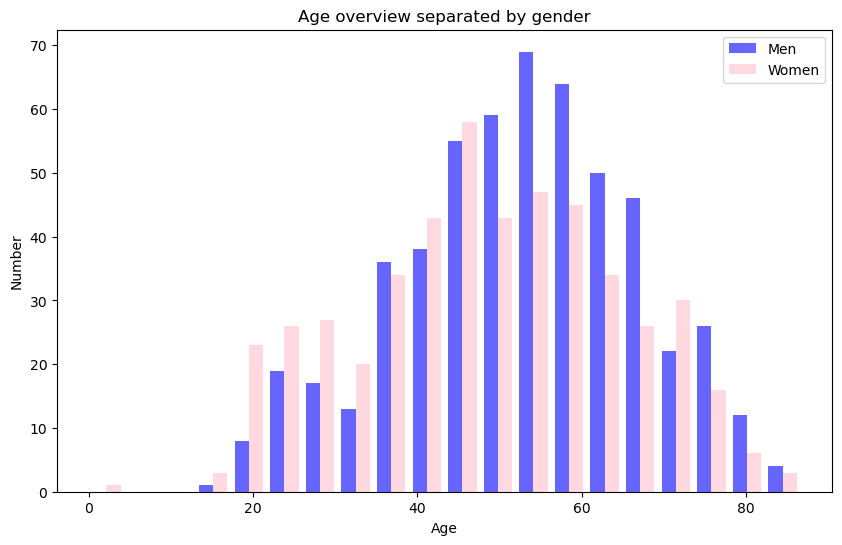

In [47]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Erstelle das Histogramm getrennt nach Geschlecht
plt.figure(figsize=(10, 6))
plt.hist([typ1[typ1['Gender'] == 'M']['Age'], typ1[typ1['Gender'] == 'F']['Age']], bins=20, alpha=0.6, color=['blue', 'pink'], label=['Men', 'Women'])
plt.xlabel('Age')
plt.ylabel('Number')
plt.title('Age overview separated by gender')
plt.legend()
plt.show()

In [48]:
# Filtern Sie die Zeilen aus d_icd, die nur die gewünschten SUBJECT_IDs enthalten
filtered_d_icd = d_icd[d_icd['SUBJECT_ID'].isin(t1_sub_id)]

# Gruppieren Sie die ICD9-Codes nach SUBJECT_ID und fügen Sie sie in einer Liste zusammen
icd_codes_by_subject = filtered_d_icd.groupby('SUBJECT_ID')['ICD9_CODE'].apply(list).to_dict()

# Zeigen Sie die resultierende Liste von ICD9-Codes für jede SUBJECT_ID an
print(icd_codes_by_subject)


{25: ['41071', '25011', '41401', '4019'], 141: ['80120', '43491', '51881', '5845', '25011', '87342', 'V667', '5990', 'E8889'], 192: ['41401', '25001', '4148', '2720', '7140', '4439'], 234: ['41071', '4241', '99672', '9971', '25041', '40391', '5856', '49320', '70703', '74190', '41401', '4239', '2859', '3441', '41071', '4280', '0389', '99592', '78552', '78551', '5990', '70703', '40391', '74190', '41401', '0416', '25040', '2859', '7847', '3441'], 263: ['25073', '25063', '25043', '25053', '40391', '7854', '5180', '3572', '58381'], 271: ['5770', '5772', '57400', '57410', '25001'], 323: ['4280', '99672', '99762', '25041', 'V420', '41401', '4582', '3694', 'V4975', '4280', '78551', '51881', '4241', '99681', '5845', '25071', '2767', '28521', '41401', 'V4976', '4401', '5939', '3693', '4019', '5363', '4148', '0389', 'V420', '486', '4280', '5849', '25093', '4148', '41401', '28521', '4439', '36900', '99592', '41071', '41401', '99762', '7854', 'V420', '51881', '4280', '2639', '25051'], 342: ['25011'

One hot encoding of the data

In [49]:
# Erstelle einen leeren DataFrame, um die One-Hot-kodierten Komorbiditäten zu speichern
one_hot_data = pd.DataFrame()

# Durchlaufe jeden Schlüssel (SUBJECT_ID) und die entsprechende Liste von ICD9-Codes in icd_codes_by_subject
for subject_id, icd_codes in icd_codes_by_subject.items():
    # Erstelle eine temporäre DataFrame für die aktuelle SUBJECT_ID und ihre ICD9-Codes
    temp_df = pd.DataFrame({icd_code: [1] for icd_code in icd_codes})
    temp_df['SUBJECT_ID'] = subject_id
    
    # Füge die temporäre DataFrame zur one_hot_data hinzu
    one_hot_data = pd.concat([one_hot_data, temp_df], ignore_index=True)

# Setze die SUBJECT_ID als Index
one_hot_data.set_index('SUBJECT_ID', inplace=True)

# Zeige das Ergebnis
print(one_hot_data)


            41071  25011  41401  4019  80120  43491  51881  5845  87342  V667  \
SUBJECT_ID                                                                      
25            1.0    1.0    1.0   1.0    NaN    NaN    NaN   NaN    NaN   NaN   
141           NaN    1.0    NaN   NaN    1.0    1.0    1.0   1.0    1.0   1.0   
192           NaN    NaN    1.0   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
234           1.0    NaN    1.0   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
263           NaN    NaN    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
...           ...    ...    ...   ...    ...    ...    ...   ...    ...   ...   
99294         NaN    NaN    NaN   1.0    NaN    NaN    NaN   NaN    NaN   NaN   
99383         NaN    NaN    NaN   NaN    NaN    NaN    1.0   NaN    NaN   NaN   
99444         NaN    NaN    NaN   NaN    NaN    NaN    1.0   NaN    NaN   NaN   
99650         NaN    NaN    1.0   NaN    NaN    NaN    1.0   NaN    NaN   NaN   
99928         NaN    NaN    

In [50]:
# One-Hot-Encoding für Geschlecht
typ1 = pd.get_dummies(typ1, columns=['Gender'], drop_first=True)

In [ ]:
typ1.to_csv('typ1.csv')  # save the preprocessed data for further clustering